In [1]:
import os
import numpy as np

import torch
torch.manual_seed(29)
from torch import nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn.parallel
cudnn.benchmark = True
from torch.utils.data import DataLoader

from torchstat import stat
from utils import  models
from utils.data import dataset_1
from utils.trainer_utils import parfilter

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
def psnr_metric(T, P, max = 1.0):
    mse = torch.mean((T - P) ** 2)
    return 20 * torch.log10(max / torch.sqrt(mse))

In [3]:
img_file = "/media/narsi/LargeData/DVI2K/DIV2K_train_HR/0001.png"

In [4]:
I = Image.open(img_file).resize((512, 512), Image.BICUBIC)

In [24]:
model = models.QuantACTShuffleV2()
check_point_file = "/media/narsi/LargeData/SP_2020/compressACT/weights/QuantACTShuffleV2_exp01/model_best.pth.tar"
checkpoint = torch.load(check_point_file)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [25]:
I1 = np.float32(I)[:64, :64, :]
I1 = np.transpose(I1, [2, 0, 1])
It = torch.from_numpy(np.expand_dims(I1, 0))/255.0

In [21]:
It = It.view(1, 3, 64, 512//64, 64, 512//64).permute(0,3,5,1,2,4).contiguous().view(-1,3,32,32)

In [26]:
X = model(It)

In [27]:
psnr_metric(It, X)

tensor(24.4271, grad_fn=<MulBackward0>)

In [28]:
from matplotlib import pyplot as plt

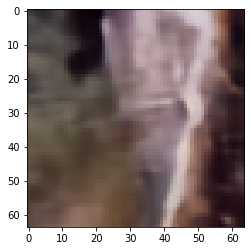

In [29]:
plt.imshow(X.squeeze().data.cpu().numpy().transpose([1, 2, 0]))

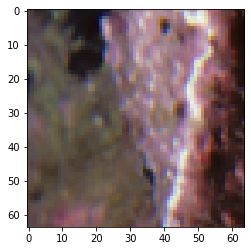

In [11]:
plt.imshow(np.uint8(I)[:64, :64, :])

In [32]:
Xe = model.encode(It)

In [2]:
model = models.QuantACTShuffleV2()

In [3]:
I = torch.randn(1, 3, 64, 64)

In [4]:
%timeit model.encode(I)

4.97 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
I = torch.randn(1, 256, 4, 4)

In [8]:
%timeit model.decode(I)

11 ms ± 37.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
X = Xe.data.cpu().numpy()

In [5]:
model.encode(I).size()

torch.Size([1, 256, 4, 4])

In [14]:
X = np.reshape(X, (-1))

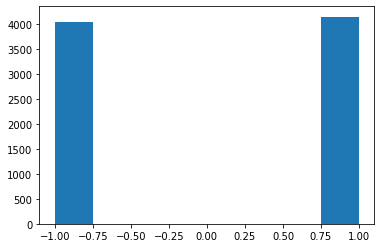

In [15]:
x = plt.hist(X, bins = 8)

In [19]:
prob = [15629.0/32768, 17139.0/32768]

In [20]:
from range_coder import RangeEncoder, RangeDecoder, prob_to_cum_freq


In [21]:
data = np.asarray(X==1, dtype = int).tolist()

# convert probabilities to cumulative integer frequency table
cumFreq = prob_to_cum_freq(prob, resolution=1024)

# encode data
encoder = RangeEncoder('test.txt')
encoder.encode(data, cumFreq)
encoder.close()

decoder = RangeDecoder('test.txt')
dataRec = decoder.decode(len(data), cumFreq)
decoder.close()

In [35]:
Xe = Xe.view(32,16,8)

In [18]:
X = Xe.data.cpu().numpy()

In [19]:
X = np.uint8(X==1)

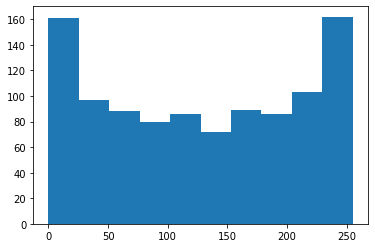

In [20]:
x = plt.hist(np.packbits(X).reshape(-1))

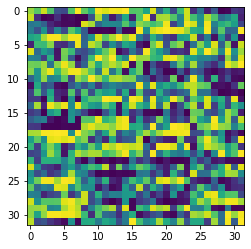

In [21]:
plt.imshow(np.packbits(X).reshape(32,32))

In [22]:
Image.fromarray(np.packbits(X).reshape(32,32)).save('test1.png')

In [30]:
Image.fromarray(np.uint8(I)[:64, :64, :]).save('test.jpg', quality = 35)

In [23]:
os.path.getsize('test1.png')/(64*64)

0.2744140625

In [24]:
os.path.getsize('test.png')/(64*64)

2.02197265625

In [31]:
os.path.getsize('test.jpg')/(64*64)

0.275146484375

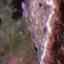

In [32]:
Image.open('test.jpg')

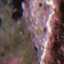

In [19]:
Image.open('test.png')

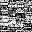

In [20]:
Image.open('test1.png')

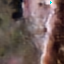

In [25]:
Image.fromarray(np.uint8(255 * X.squeeze().data.cpu().numpy().transpose([1, 2, 0])))